In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import exp, abs, log
from scipy.special import gamma, factorial
import os
import scipy.stats as stats
import statsmodels.api as sm
from utils import *
import time
import datetime as dt
import universal as up
from universal import tools, algos
from universal.algos import *
from strategies import *
from metrics import *
import universal as up
from universal import tools, algos
from universal.result import AlgoResult, ListResult

np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
np.set_printoptions(threshold=np.inf)

In [56]:
def run(paras, strategy_lst, figsize=(10,5), phase_cnt=12):
    maxiter, subn, lb, c = paras['maxiter'], paras['subn'], paras['lb'], paras['c']

    results = []
    concat_result_dict = {}
    for phs in range(0, phase_cnt):
        print('Phase %d' % phs)
        if paras['dataset']=='snp500-12':
            data_path1 = './stock_data/stock_phase%02d_lb%d.npz' % (phs, lb)
        elif paras['dataset']=='snp500-24':
            data_path1 = './stock_data/stock24_phase%02d_lb%d.npz' % (phs, lb)
        data = np.load(data_path1)
        cov_train, choice = data['cov_train'], data['choice']
        if paras['inverse']:
            choice = choice[::-1]
        cov = cov_train[choice[:subn], :][:, choice[:subn]]

        print('Testing...')
        predY0, std_varY0, sample_Y0 = get_res(paras, phs, maxiter, subn, lb)
        
#         strategy_lst = ['ucb_strategy(0, predY0, std_varY0, sample_Y0)', 
#                         'opt_strategy(predY0, std_var_Y0, sample_Y0, cov, paras["opt_delta"])', 
#                         'passive_strategy(predY0, std_var_Y0, sample_Y0, cov, paras["passive_eps"], paras["passive_delta"])']
#         metrics_lst =['cumulative_return(rt_v)', 'daily_return(rt_v)', 'max_redraw(rt_v)']
        
        result_dict = {}        
        for strategy in strategy_lst:
            strategy_name = strategy.split('(')[0]
            print(strategy_name)
            rt_v, x_vec = eval(strategy)
            result_dict[strategy_name] = [rt_v.copy(), x_vec.copy(), [exp(sample_Y0.copy())]]
            if strategy_name in concat_result_dict:
                concat_result_dict[strategy_name][0] += rt_v.copy()
                concat_result_dict[strategy_name][1] += x_vec.copy()
                concat_result_dict[strategy_name][2] += [exp(sample_Y0).copy()]
            else:
                concat_result_dict[strategy_name] = [rt_v.copy(), x_vec.copy(), [exp(sample_Y0).copy()]]
#             for metric in metrics_lst:
#                 metric_name = metric.split('(')[0]     
#                 res = eval(metric)
#                 print('\t%s: %.8f' % (metric_name, res))
        results.append(result_dict)
                
#     print()
#     print('===========================overall results===========================')
#     for strategy in strategy_lst:
#         strategy_name = strategy.split('(')[0]
#         print(strategy_name)
#         rt_v, x_vec = concat_result_dict[strategy_name]
#         for metric in metrics_lst:
#             metric_name = metric.split('(')[0]     
#             res = eval(metric)
#             print('\t%s: %.8f' % (metric_name, res))

    return results, concat_result_dict

In [57]:
def display(strategy_name, concat_results, paras, figsize=(10,5)):
    rt_v, x_vec, sample_Y0 = concat_results[strategy_name]
    B = np.concatenate([v.reshape(1,-1) for v in x_vec], axis=0)
    B = pd.DataFrame(B)
    Y = pd.DataFrame(np.concatenate(sample_Y0, axis=0))
    result = AlgoResult(Y, B)
    result.set_rf_rate(paras['rf'])
    print('========================================================')
    print(strategy_name)
    print('--------------------------------------------------------')
    print('fee = 0')
    print(result.summary())
    print('Total wealth:', result.total_wealth)
    plt.figure(figsize=figsize)
    result.plot(weights=False, assets=False, ucrp=True, logy=False)
    plt.show()
    print('--------------------------------------------------------')
    c=0.001
    print('fee = %f'%c)
    result.fee = c
    print(result.summary())
    print('Total wealth:', result.total_wealth)
    plt.figure(figsize=figsize)
    result.plot(weights=False, assets=False, ucrp=True, logy=False)
    plt.show()
    print('--------------------------------------------------------')
    c=0.0025
    print('fee = %f'%c)
    result.fee = c
    print(result.summary())
    print('Total wealth:', result.total_wealth)
    plt.figure(figsize=figsize)
    result.plot(weights=False, assets=False, ucrp=True, logy=False)
    plt.show()
    print('--------------------------------------------------------')
    c=0.005
    print('fee = %f'%c)
    result.fee = c
    print(result.summary())
    print('Total wealth:', result.total_wealth)
    plt.figure()
    result.plot(weights=False, assets=False, ucrp=True, logy=False)
    plt.show()
    print()

In [58]:
def display_phs(strategy_name, results, phs, paras, figsize=(10,5)):
    print('========================================================')
    print('Phase %d'%phs)
    for strategy in strategy_lst:
        strategy_name = strategy.split('(')[0]
        rt_v, x_vec, sample_Y0 = results[phs][strategy_name]
        
        B = np.concatenate([v.reshape(1,-1) for v in x_vec], axis=0)
        B = pd.DataFrame(B)
        Y = pd.DataFrame(sample_Y0[0])
#         print(B.shape)
#         print(Y.shape)
        result = AlgoResult(Y, B)
        result.set_rf_rate(paras['rf'])
        print(strategy_name)
        print('--------------------------------------------------------')
        print('fee = 0')
        print(result.summary())
        print('Total wealth:', result.total_wealth)

In [59]:
strategy_lst = [#'ucb_strategy(0, predY0, std_varY0, sample_Y0)', 
                'opt_strategy(predY0, std_varY0, sample_Y0, cov, paras["opt_gamma"])', 
                'passive_strategy2(predY0, std_varY0, sample_Y0, cov, paras["passive_eps"], paras["passive_gamma"])'
               ]

# HATS

## HATS mat 30 + GGD

    #!/bin/bash

    maxiter=5000
    subn=100
    lb=5
    M=20
    inverse='True'
    ggd='True'
    matid='48 35 83 25 84 19 21 71 24 68 81 38 51 56 77 43 80 15 30 60 69 37 73 62 34 54 57 70 39 42'

    matcnt=$(echo ${matid} | wc -w)
    for i in `seq 0 11`;
    # for i in 10;
    do
        echo "phase $i"
            python main2.py --phase $i --maxiter ${maxiter} --subn ${subn} --lb ${lb} --inverse ${inverse} --matid ${matid} --M ${M} --ggd ${ggd} --gpu 1  > ./log/main2_noval_inv${inverse}_ggd${ggd}_M${M}_iter${maxiter}_mat${matcnt}_subn${subn}_lb5_s5_log${i}.log
    done

In [ ]:
paras={'dataset':'snp500-12', 'maxiter':5000, 'subn':100, 'lb':5, 'M':20, 'inverse':'True', 'ggd':'True', 'matcnt':30, 
       'c':0.001, 'rf':0.0007, 'opt_gamma':3, 'passive_eps':1.001, 'passive_gamma':3,
       'mattype':0, 'dg':0
      }

results, concat_results = run(paras, strategy_lst, phase_cnt=12)
# plot_cumulative_return_history(concat_results, strategy_lst, figsize=(10,5))

ucb_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.18
    Sharpe ratio: 1.10 ± 0.58
    Ulcer index: 4.30
    Information ratio (wrt UCRP): 1.22
    Appraisal ratio (wrt UCRP): 0.97 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.12 / 12.206%
    Annualized return: 26.49%
    Annualized volatility: 23.78%
    Longest drawdown: 104 days
    Max drawdown: 28.81%
    Winning days: 54.8%
    Annual turnover: 377.8
        
Total wealth: 3.06232366856829


<Figure size 720x360 with 0 Axes>

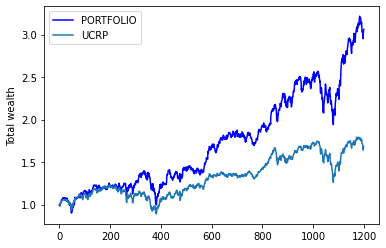

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 0.90
    Sharpe ratio: -0.48 ± 0.48
    Ulcer index: -0.30
    Information ratio (wrt UCRP): -2.16
    Appraisal ratio (wrt UCRP): -2.04 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.11 / -25.516%
    Annualized return: -13.27%
    Annualized volatility: 23.72%
    Longest drawdown: 1185 days
    Max drawdown: 63.85%
    Winning days: 49.3%
    Annual turnover: 377.8
        
Total wealth: 0.5077076272370127


<Figure size 720x360 with 0 Axes>

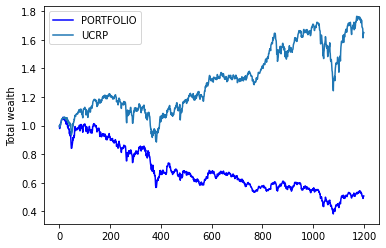

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.60
    Sharpe ratio: -2.88 ± 1.04
    Ulcer index: -0.88
    Information ratio (wrt UCRP): -7.27
    Appraisal ratio (wrt UCRP): -6.57 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.11 / -82.099%
    Annualized return: -50.81%
    Annualized volatility: 23.65%
    Longest drawdown: 1185 days
    Max drawdown: 96.76%
    Winning days: 41.5%
    Annual turnover: 377.8
        
Total wealth: 0.03409530831434735


<Figure size 720x360 with 0 Axes>

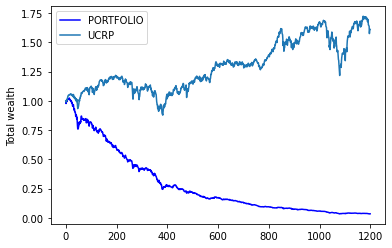

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.30
    Sharpe ratio: -6.89 ± 2.28
    Ulcer index: -1.81
    Information ratio (wrt UCRP): -15.72
    Appraisal ratio (wrt UCRP): -14.06 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.10 / -176.405%
    Annualized return: -80.94%
    Annualized volatility: 23.58%
    Longest drawdown: 1199 days
    Max drawdown: 99.96%
    Winning days: 30.1%
    Annual turnover: 377.8
        
Total wealth: 0.0003730464598193627


<Figure size 432x288 with 0 Axes>

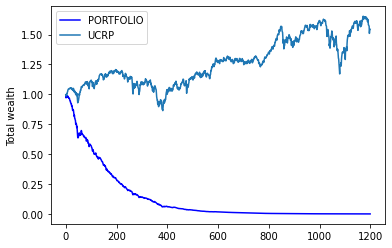


opt_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.18
    Sharpe ratio: 1.09 ± 0.58
    Ulcer index: 4.80
    Information ratio (wrt UCRP): 1.02
    Appraisal ratio (wrt UCRP): 0.84 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.17 / 16.368%
    Annualized return: 31.15%
    Annualized volatility: 28.40%
    Longest drawdown: 116 days
    Max drawdown: 26.05%
    Winning days: 53.8%
    Annual turnover: 432.5
        
Total wealth: 3.6373681719988693


<Figure size 720x360 with 0 Axes>

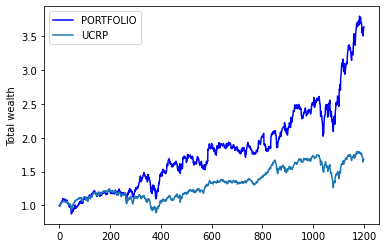

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 0.91
    Sharpe ratio: -0.43 ± 0.48
    Ulcer index: -0.28
    Information ratio (wrt UCRP): -1.37
    Appraisal ratio (wrt UCRP): -1.38 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.16 / -26.810%
    Annualized return: -14.85%
    Annualized volatility: 28.34%
    Longest drawdown: 1185 days
    Max drawdown: 69.57%
    Winning days: 49.2%
    Annual turnover: 432.5
        
Total wealth: 0.46504669766267254


<Figure size 720x360 with 0 Axes>

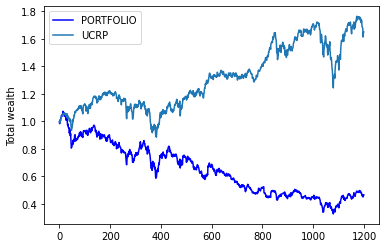

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.61
    Sharpe ratio: -2.72 ± 0.99
    Ulcer index: -0.96
    Information ratio (wrt UCRP): -4.96
    Appraisal ratio (wrt UCRP): -4.72 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.16 / -91.578%
    Annualized return: -55.52%
    Annualized volatility: 28.25%
    Longest drawdown: 1185 days
    Max drawdown: 98.06%
    Winning days: 40.7%
    Annual turnover: 432.5
        
Total wealth: 0.02111415740262894


<Figure size 720x360 with 0 Axes>

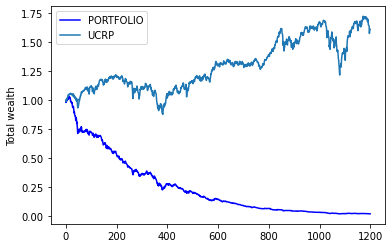

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.32
    Sharpe ratio: -6.57 ± 2.18
    Ulcer index: -2.03
    Information ratio (wrt UCRP): -10.93
    Appraisal ratio (wrt UCRP): -10.27 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.15 / -199.524%
    Annualized return: -84.99%
    Annualized volatility: 28.17%
    Longest drawdown: 1199 days
    Max drawdown: 99.99%
    Winning days: 30.8%
    Annual turnover: 432.5
        
Total wealth: 0.00011977207395389042


<Figure size 432x288 with 0 Axes>

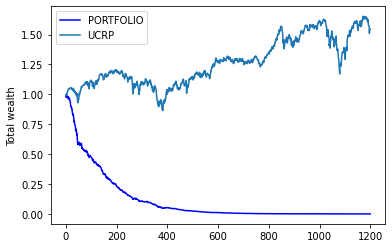


passive_strategy2
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.12
    Sharpe ratio: 0.74 ± 0.52
    Ulcer index: 2.08
    Information ratio (wrt UCRP): 0.20
    Appraisal ratio (wrt UCRP): 0.28 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.94 / 1.829%
    Annualized return: 12.74%
    Annualized volatility: 18.37%
    Longest drawdown: 283 days
    Max drawdown: 27.99%
    Winning days: 53.6%
    Annual turnover: 10.6
        
Total wealth: 1.769887563909384


<Figure size 720x360 with 0 Axes>

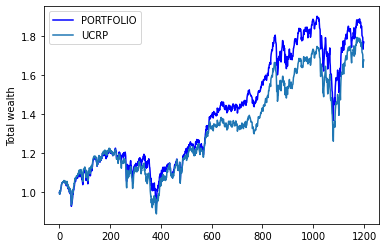

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 1.11
    Sharpe ratio: 0.68 ± 0.51
    Ulcer index: 1.85
    Information ratio (wrt UCRP): -0.01
    Appraisal ratio (wrt UCRP): 0.12 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / 0.754%
    Annualized return: 11.53%
    Annualized volatility: 18.36%
    Longest drawdown: 294 days
    Max drawdown: 28.09%
    Winning days: 53.4%
    Annual turnover: 10.6
        
Total wealth: 1.6812621011223712


<Figure size 720x360 with 0 Axes>

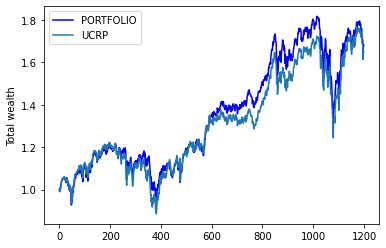

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 1.09
    Sharpe ratio: 0.59 ± 0.50
    Ulcer index: 1.51
    Information ratio (wrt UCRP): -0.33
    Appraisal ratio (wrt UCRP): -0.13 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / -0.858%
    Annualized return: 9.74%
    Annualized volatility: 18.34%
    Longest drawdown: 378 days
    Max drawdown: 28.25%
    Winning days: 52.8%
    Annual turnover: 10.6
        
Total wealth: 1.5565259084614849


<Figure size 720x360 with 0 Axes>

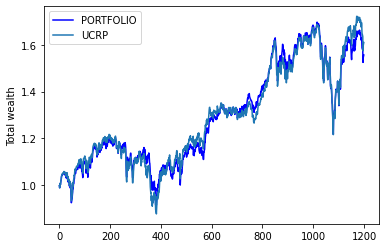

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 1.07
    Sharpe ratio: 0.45 ± 0.48
    Ulcer index: 0.99
    Information ratio (wrt UCRP): -0.85
    Appraisal ratio (wrt UCRP): -0.54 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / -3.545%
    Annualized return: 6.81%
    Annualized volatility: 18.33%
    Longest drawdown: 394 days
    Max drawdown: 28.51%
    Winning days: 52.5%
    Annual turnover: 10.6
        
Total wealth: 1.3687411241828766


<Figure size 432x288 with 0 Axes>

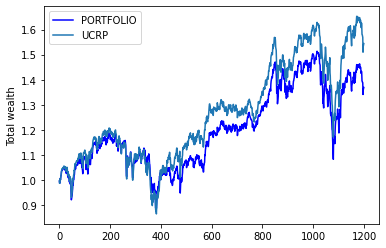

In [51]:
for strategy in strategy_lst:
    strategy_name = strategy.split('(')[0]
    display(strategy_name, concat_results, paras)

In [52]:
for phs in range(12):
    display_phs(strategy_name, results, phs, paras)

Phase 0
ucb_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.30
    Sharpe ratio: 1.70 ± 2.48
    Ulcer index: 7.78
    Information ratio (wrt UCRP): 0.81
    Appraisal ratio (wrt UCRP): -0.08 ± 1.61
    UCRP sharpe: 1.90 ± 2.66
    Beta / Alpha: 1.31 / -0.861%
    Annualized return: 45.66%
    Annualized volatility: 23.71%
    Longest drawdown: 47 days
    Max drawdown: 16.73%
    Winning days: 61.0%
    Annual turnover: 352.0
        
Total wealth: 1.1609476180587948
opt_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.16
    Sharpe ratio: 1.02 ± 1.96
    Ulcer index: 3.02
    Information ratio (wrt UCRP): -0.37
    Appraisal ratio (wrt UCRP): -0.99 ± 1.61
    UCRP sharpe: 1.90 ± 2.66
    Beta / Alpha: 1.31 / -15.184%
    Annualized return: 25.71%
    Annualized volatility: 25.65%
    Longest drawdown: 85 days
    Max drawdown: 20.60%
    Winning days: 59.0%
    Annual turnov

Summary:
    Profit factor: 1.37
    Sharpe ratio: 1.96 ± 2.71
    Ulcer index: 12.98
    Information ratio (wrt UCRP): 0.99
    Appraisal ratio (wrt UCRP): 0.65 ± 1.61
    UCRP sharpe: 2.08 ± 2.82
    Beta / Alpha: 1.11 / 8.847%
    Annualized return: 48.39%
    Annualized volatility: 21.29%
    Longest drawdown: 57 days
    Max drawdown: 7.28%
    Winning days: 54.0%
    Annual turnover: 394.9
        
Total wealth: 1.1695419372361922
opt_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.20
    Sharpe ratio: 1.17 ± 2.06
    Ulcer index: 5.57
    Information ratio (wrt UCRP): 0.22
    Appraisal ratio (wrt UCRP): -0.02 ± 1.61
    UCRP sharpe: 2.08 ± 2.82
    Beta / Alpha: 1.19 / -0.389%
    Annualized return: 35.72%
    Annualized volatility: 29.61%
    Longest drawdown: 79 days
    Max drawdown: 12.73%
    Winning days: 50.0%
    Annual turnover: 446.0
        
Total wealth: 1.1288473794713483
passive_strategy2
--------------------

Summary:
    Profit factor: 1.03
    Sharpe ratio: 0.39 ± 1.65
    Ulcer index: 1.59
    Information ratio (wrt UCRP): 2.52
    Appraisal ratio (wrt UCRP): 3.01 ± 1.60
    UCRP sharpe: -1.43 ± 2.26
    Beta / Alpha: 1.29 / 63.929%
    Annualized return: 7.95%
    Annualized volatility: 38.89%
    Longest drawdown: 72 days
    Max drawdown: 22.47%
    Winning days: 50.0%
    Annual turnover: 428.9
        
Total wealth: 1.0308204917411843
passive_strategy2
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 0.75
    Sharpe ratio: -1.48 ± 2.30
    Ulcer index: -3.03
    Information ratio (wrt UCRP): -1.00
    Appraisal ratio (wrt UCRP): -0.24 ± 1.60
    UCRP sharpe: -1.43 ± 2.26
    Beta / Alpha: 1.01 / -0.645%
    Annualized return: -34.62%
    Annualized volatility: 26.42%
    Longest drawdown: 84 days
    Max drawdown: 27.99%
    Winning days: 43.0%
    Annual turnover: 5.1
        
Total wealth: 0.8448411953623328
Phase 11
ucb_strategy
-------

## No graph + GGD

    #!/bin/bash

    maxiter=5000
    subn=100
    lb=5
    M=20
    inverse='True'
    ggd='True'
    matid=''

    matcnt=$(echo ${matid} | wc -w)
    for i in `seq 0 11`;
    # for i in 10;
    do
        echo "phase $i"
            python main2.py --phase $i --maxiter ${maxiter} --subn ${subn} --lb ${lb} --inverse ${inverse} --matid ${matid} --M ${M} --ggd ${ggd} --gpu 1  > ./log/main2_noval_inv${inverse}_ggd${ggd}_M${M}_iter${maxiter}_mat${matcnt}_subn${subn}_lb5_s5_log${i}.log
    done

In [53]:
paras={'dataset':'snp500-12', 'maxiter':5000, 'subn':100, 'lb':5, 'M':20, 'inverse':'True', 'ggd':'True', 'matcnt':0, 
       'c':0.001, 'rf':0.0007, 'opt_gamma':3, 'passive_eps':1.001, 'passive_gamma':3,
       'mattype':0, 'dg':0
      }

results, concat_results = run(paras, strategy_lst, phase_cnt=12)
# plot_cumulative_return_history(concat_results, strategy_lst, figsize=(10,5))

Phase 0
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 1
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 2
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 3
Testing...
ucb_strategy
opt_strategy
passive_strategy2


/home/linaiqi/anaconda3/envs/gpfinance/lib/python3.7/site-packages/cvxpy/problems/problem.py:1061: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


Phase 4
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 5
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 6
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 7
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 8
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 9
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 10
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 11
Testing...
ucb_strategy
opt_strategy
passive_strategy2


ucb_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.18
    Sharpe ratio: 1.07 ± 0.57
    Ulcer index: 3.71
    Information ratio (wrt UCRP): 1.15
    Appraisal ratio (wrt UCRP): 0.91 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.12 / 11.408%
    Annualized return: 25.55%
    Annualized volatility: 23.91%
    Longest drawdown: 238 days
    Max drawdown: 31.90%
    Winning days: 55.2%
    Annual turnover: 376.8
        
Total wealth: 2.9550067433508027


<Figure size 720x360 with 0 Axes>

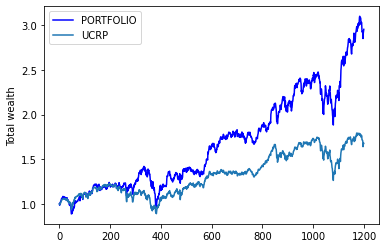

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 0.90
    Sharpe ratio: -0.51 ± 0.49
    Ulcer index: -0.30
    Information ratio (wrt UCRP): -2.21
    Appraisal ratio (wrt UCRP): -2.09 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.12 / -26.218%
    Annualized return: -13.83%
    Annualized volatility: 23.85%
    Longest drawdown: 1185 days
    Max drawdown: 64.88%
    Winning days: 49.9%
    Annual turnover: 376.8
        
Total wealth: 0.4921395437379419


<Figure size 720x360 with 0 Axes>

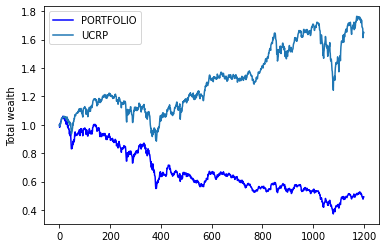

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.59
    Sharpe ratio: -2.88 ± 1.04
    Ulcer index: -0.88
    Information ratio (wrt UCRP): -7.27
    Appraisal ratio (wrt UCRP): -6.59 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.12 / -82.658%
    Annualized return: -51.06%
    Annualized volatility: 23.78%
    Longest drawdown: 1185 days
    Max drawdown: 96.85%
    Winning days: 41.7%
    Annual turnover: 376.8
        
Total wealth: 0.03327589435270611


<Figure size 720x360 with 0 Axes>

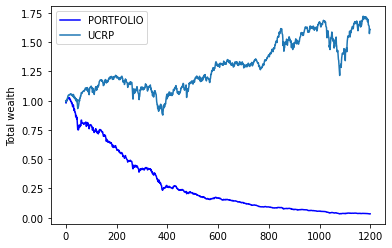

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.30
    Sharpe ratio: -6.86 ± 2.27
    Ulcer index: -1.81
    Information ratio (wrt UCRP): -15.65
    Appraisal ratio (wrt UCRP): -14.04 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.11 / -176.724%
    Annualized return: -80.99%
    Annualized volatility: 23.71%
    Longest drawdown: 1199 days
    Max drawdown: 99.96%
    Winning days: 29.8%
    Annual turnover: 376.8
        
Total wealth: 0.0003682633166360388


<Figure size 432x288 with 0 Axes>

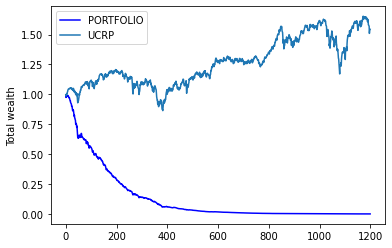


opt_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.16
    Sharpe ratio: 0.99 ± 0.56
    Ulcer index: 4.05
    Information ratio (wrt UCRP): 0.85
    Appraisal ratio (wrt UCRP): 0.69 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.17 / 13.467%
    Annualized return: 27.43%
    Annualized volatility: 28.61%
    Longest drawdown: 116 days
    Max drawdown: 30.26%
    Winning days: 53.2%
    Annual turnover: 431.8
        
Total wealth: 3.1721115016023385


<Figure size 720x360 with 0 Axes>

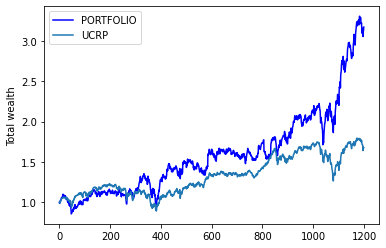

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 0.89
    Sharpe ratio: -0.52 ± 0.49
    Ulcer index: -0.30
    Information ratio (wrt UCRP): -1.50
    Appraisal ratio (wrt UCRP): -1.51 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.17 / -29.641%
    Annualized return: -17.21%
    Annualized volatility: 28.54%
    Longest drawdown: 1185 days
    Max drawdown: 73.08%
    Winning days: 49.0%
    Annual turnover: 431.8
        
Total wealth: 0.40687967895666477


<Figure size 720x360 with 0 Axes>

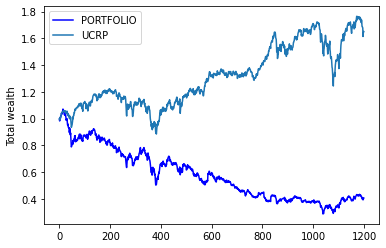

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.60
    Sharpe ratio: -2.80 ± 1.02
    Ulcer index: -0.98
    Information ratio (wrt UCRP): -5.05
    Appraisal ratio (wrt UCRP): -4.82 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.17 / -94.304%
    Annualized return: -56.71%
    Annualized volatility: 28.47%
    Longest drawdown: 1185 days
    Max drawdown: 98.25%
    Winning days: 40.8%
    Annual turnover: 431.8
        
Total wealth: 0.018563720647453326


<Figure size 720x360 with 0 Axes>

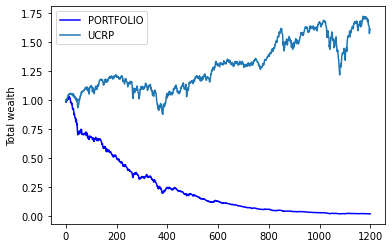

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.31
    Sharpe ratio: -6.60 ± 2.19
    Ulcer index: -2.05
    Information ratio (wrt UCRP): -10.95
    Appraisal ratio (wrt UCRP): -10.31 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.16 / -202.076%
    Annualized return: -85.36%
    Annualized volatility: 28.39%
    Longest drawdown: 1199 days
    Max drawdown: 99.99%
    Winning days: 30.8%
    Annual turnover: 431.8
        
Total wealth: 0.00010617167273437896


<Figure size 432x288 with 0 Axes>

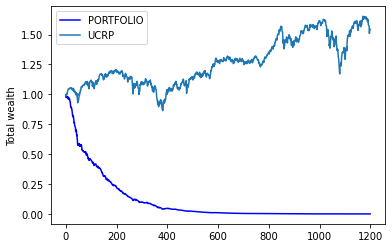


passive_strategy2
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.12
    Sharpe ratio: 0.75 ± 0.52
    Ulcer index: 2.04
    Information ratio (wrt UCRP): 0.25
    Appraisal ratio (wrt UCRP): 0.31 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.94 / 2.099%
    Annualized return: 13.06%
    Annualized volatility: 18.45%
    Longest drawdown: 282 days
    Max drawdown: 28.18%
    Winning days: 54.1%
    Annual turnover: 10.5
        
Total wealth: 1.7942948580922693


<Figure size 720x360 with 0 Axes>

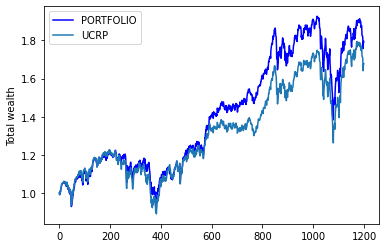

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 1.11
    Sharpe ratio: 0.70 ± 0.51
    Ulcer index: 1.82
    Information ratio (wrt UCRP): 0.05
    Appraisal ratio (wrt UCRP): 0.15 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.94 / 1.028%
    Annualized return: 11.85%
    Annualized volatility: 18.44%
    Longest drawdown: 319 days
    Max drawdown: 28.29%
    Winning days: 53.8%
    Annual turnover: 10.5
        
Total wealth: 1.7048286727542574


<Figure size 720x360 with 0 Axes>

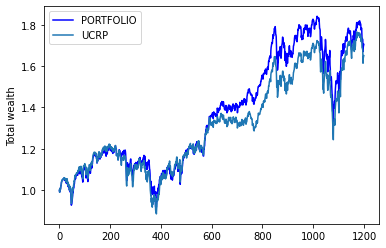

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 1.10
    Sharpe ratio: 0.61 ± 0.50
    Ulcer index: 1.49
    Information ratio (wrt UCRP): -0.26
    Appraisal ratio (wrt UCRP): -0.09 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.94 / -0.578%
    Annualized return: 10.07%
    Annualized volatility: 18.43%
    Longest drawdown: 378 days
    Max drawdown: 28.44%
    Winning days: 53.5%
    Annual turnover: 10.5
        
Total wealth: 1.5788743187394474


<Figure size 720x360 with 0 Axes>

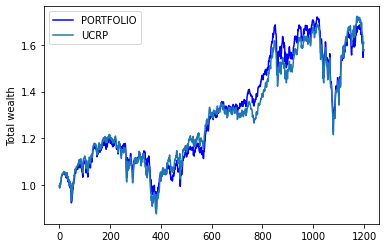

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 1.07
    Sharpe ratio: 0.46 ± 0.48
    Ulcer index: 0.99
    Information ratio (wrt UCRP): -0.77
    Appraisal ratio (wrt UCRP): -0.48 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.94 / -3.254%
    Annualized return: 7.15%
    Annualized volatility: 18.42%
    Longest drawdown: 393 days
    Max drawdown: 28.70%
    Winning days: 53.2%
    Annual turnover: 10.5
        
Total wealth: 1.389171853351041


<Figure size 432x288 with 0 Axes>

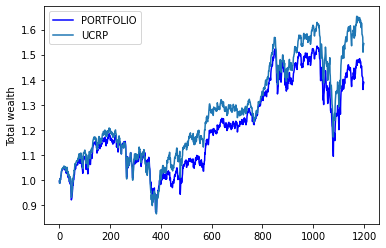

In [54]:
for strategy in strategy_lst:
    strategy_name = strategy.split('(')[0]
    display(strategy_name, concat_results, paras)

In [55]:
for phs in range(12):
    display_phs(strategy_name, results, phs, paras)

Phase 0
ucb_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.23
    Sharpe ratio: 1.32 ± 2.17
    Ulcer index: 4.73
    Information ratio (wrt UCRP): -0.04
    Appraisal ratio (wrt UCRP): -0.86 ± 1.61
    UCRP sharpe: 1.90 ± 2.66
    Beta / Alpha: 1.30 / -9.767%
    Annualized return: 32.82%
    Annualized volatility: 23.61%
    Longest drawdown: 68 days
    Max drawdown: 18.10%
    Winning days: 59.0%
    Annual turnover: 345.9
        
Total wealth: 1.1192109720549985
opt_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.05
    Sharpe ratio: 0.40 ± 1.65
    Ulcer index: 0.95
    Information ratio (wrt UCRP): -1.42
    Appraisal ratio (wrt UCRP): -2.03 ± 1.61
    UCRP sharpe: 1.90 ± 2.66
    Beta / Alpha: 1.33 / -31.446%
    Annualized return: 7.31%
    Annualized volatility: 25.98%
    Longest drawdown: 85 days
    Max drawdown: 22.25%
    Winning days: 55.0%
    Annual turnov

Summary:
    Profit factor: 1.38
    Sharpe ratio: 2.04 ± 2.79
    Ulcer index: 13.92
    Information ratio (wrt UCRP): 1.16
    Appraisal ratio (wrt UCRP): 0.77 ± 1.61
    UCRP sharpe: 2.08 ± 2.82
    Beta / Alpha: 1.12 / 10.475%
    Annualized return: 51.34%
    Annualized volatility: 21.41%
    Longest drawdown: 57 days
    Max drawdown: 7.38%
    Winning days: 54.0%
    Annual turnover: 392.4
        
Total wealth: 1.178715793045157
opt_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.18
    Sharpe ratio: 1.08 ± 1.99
    Ulcer index: 4.80
    Information ratio (wrt UCRP): 0.09
    Appraisal ratio (wrt UCRP): -0.13 ± 1.61
    UCRP sharpe: 2.08 ± 2.82
    Beta / Alpha: 1.18 / -3.134%
    Annualized return: 31.74%
    Annualized volatility: 29.47%
    Longest drawdown: 79 days
    Max drawdown: 13.06%
    Winning days: 47.0%
    Annual turnover: 445.7
        
Total wealth: 1.1156081348529343
passive_strategy2
--------------------

Summary:
    Profit factor: 0.75
    Sharpe ratio: -1.50 ± 2.32
    Ulcer index: -3.04
    Information ratio (wrt UCRP): -1.55
    Appraisal ratio (wrt UCRP): -0.47 ± 1.60
    UCRP sharpe: -1.43 ± 2.26
    Beta / Alpha: 1.02 / -1.283%
    Annualized return: -35.05%
    Annualized volatility: 26.44%
    Longest drawdown: 84 days
    Max drawdown: 28.18%
    Winning days: 42.0%
    Annual turnover: 5.1
        
Total wealth: 0.8425879508776917
Phase 11
ucb_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.61
    Sharpe ratio: 2.89 ± 3.62
    Ulcer index: 29.60
    Information ratio (wrt UCRP): 4.48
    Appraisal ratio (wrt UCRP): 3.50 ± 1.60
    UCRP sharpe: 2.00 ± 2.75
    Beta / Alpha: 1.10 / 33.209%
    Annualized return: 98.95%
    Annualized volatility: 24.82%
    Longest drawdown: 17 days
    Max drawdown: 8.05%
    Winning days: 60.0%
    Annual turnover: 358.6
        
Total wealth: 1.3138596161222449
opt_strategy
------------

## HATS mat 30 + No GGD

    #!/bin/bash

    maxiter=5000
    subn=100
    lb=5
    M=20
    inverse='True'
    ggd='False'
    matid='48 35 83 25 84 19 21 71 24 68 81 38 51 56 77 43 80 15 30 60 69 37 73 62 34 54 57 70 39 42'

    matcnt=$(echo ${matid} | wc -w)
    for i in `seq 0 11`;
    # for i in 10;
    do
        echo "phase $i"
                python main2.py --phase $i --maxiter ${maxiter} --subn ${subn} --lb ${lb} --inverse ${inverse} --matid ${matid} --M ${M} --ggd ${ggd} --gpu 1  > ./log/main2_noval_inv${inverse}_ggd${ggd}_M${M}_iter${maxiter}_mat${matcnt}_subn${subn}_lb5_s5_log${i}.log
    done

In [15]:
paras={'dataset':'snp500-12', 'maxiter':5000, 'subn':100, 'lb':5, 'M':20, 'inverse':'True', 'ggd':'False', 'matcnt':30, 
       'c':0.001, 'rf':0.0007, 'opt_gamma':3, 'passive_eps':1.001, 'passive_gamma':3,
       'mattype':0, 'dg':0
      }

results, concat_results = run(paras, strategy_lst, phase_cnt=12)

Phase 0
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 1
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 2
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 3
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 4
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 5
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 6
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 7
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 8
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 9
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 10
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 11
Testing...
ucb_strategy
opt_strategy
passive_strategy2


ucb_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.09
    Sharpe ratio: 0.60 ± 0.50
    Ulcer index: 1.77
    Information ratio (wrt UCRP): 0.12
    Appraisal ratio (wrt UCRP): 0.04 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.06 / 0.584%
    Annualized return: 12.04%
    Annualized volatility: 23.11%
    Longest drawdown: 197 days
    Max drawdown: 31.85%
    Winning days: 53.8%
    Annual turnover: 359.0
        


<Figure size 720x360 with 0 Axes>

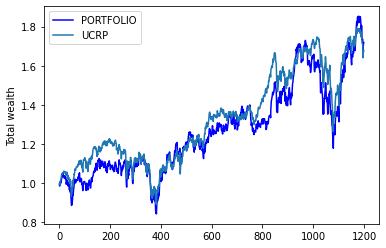

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 0.83
    Sharpe ratio: -0.95 ± 0.55
    Ulcer index: -0.44
    Information ratio (wrt UCRP): -3.02
    Appraisal ratio (wrt UCRP): -2.73 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.06 / -35.308%
    Annualized return: -21.77%
    Annualized volatility: 23.06%
    Longest drawdown: 1185 days
    Max drawdown: 75.44%
    Winning days: 49.0%
    Annual turnover: 359.0
        


<Figure size 720x360 with 0 Axes>

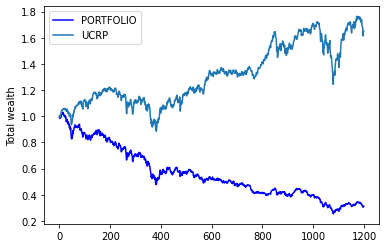

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.56
    Sharpe ratio: -3.30 ± 1.16
    Ulcer index: -0.95
    Information ratio (wrt UCRP): -7.76
    Appraisal ratio (wrt UCRP): -6.90 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.06 / -89.147%
    Annualized return: -54.40%
    Annualized volatility: 22.99%
    Longest drawdown: 1185 days
    Max drawdown: 97.66%
    Winning days: 41.8%
    Annual turnover: 359.0
        


<Figure size 720x360 with 0 Axes>

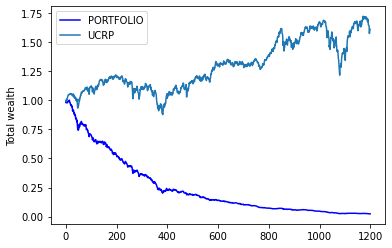

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.28
    Sharpe ratio: -7.23 ± 2.39
    Ulcer index: -1.83
    Information ratio (wrt UCRP): -15.64
    Appraisal ratio (wrt UCRP): -13.83 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.05 / -178.879%
    Annualized return: -81.50%
    Annualized volatility: 22.92%
    Longest drawdown: 1199 days
    Max drawdown: 99.97%
    Winning days: 29.9%
    Annual turnover: 359.0
        


<Figure size 432x288 with 0 Axes>

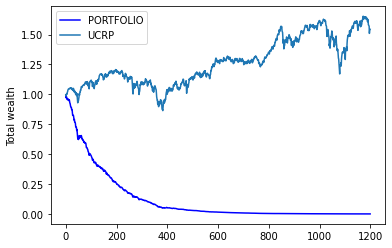


opt_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.02
    Sharpe ratio: 0.26 ± 0.47
    Ulcer index: 0.43
    Information ratio (wrt UCRP): -0.27
    Appraisal ratio (wrt UCRP): -0.30 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.08 / -6.228%
    Annualized return: 3.58%
    Annualized volatility: 27.96%
    Longest drawdown: 230 days
    Max drawdown: 48.00%
    Winning days: 53.5%
    Annual turnover: 425.2
        


<Figure size 720x360 with 0 Axes>

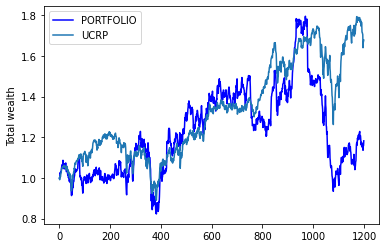

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 0.78
    Sharpe ratio: -1.26 ± 0.61
    Ulcer index: -0.61
    Information ratio (wrt UCRP): -2.49
    Appraisal ratio (wrt UCRP): -2.35 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.08 / -48.695%
    Annualized return: -32.30%
    Annualized volatility: 27.90%
    Longest drawdown: 1185 days
    Max drawdown: 86.28%
    Winning days: 48.2%
    Annual turnover: 425.2
        


<Figure size 720x360 with 0 Axes>

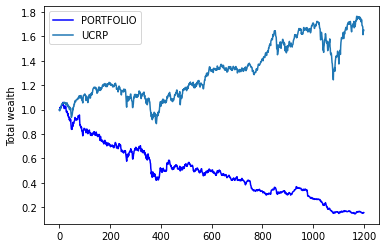

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.53
    Sharpe ratio: -3.55 ± 1.24
    Ulcer index: -1.19
    Information ratio (wrt UCRP): -5.82
    Appraisal ratio (wrt UCRP): -5.43 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.07 / -112.395%
    Annualized return: -64.28%
    Annualized volatility: 27.84%
    Longest drawdown: 1185 days
    Max drawdown: 99.29%
    Winning days: 39.2%
    Annual turnover: 425.2
        


<Figure size 720x360 with 0 Axes>

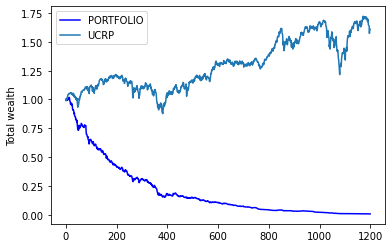

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.27
    Sharpe ratio: -7.39 ± 2.44
    Ulcer index: -2.22
    Information ratio (wrt UCRP): -11.32
    Appraisal ratio (wrt UCRP): -10.52 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.06 / -218.563%
    Annualized return: -87.74%
    Annualized volatility: 27.77%
    Longest drawdown: 1197 days
    Max drawdown: 100.00%
    Winning days: 27.8%
    Annual turnover: 425.2
        


<Figure size 432x288 with 0 Axes>

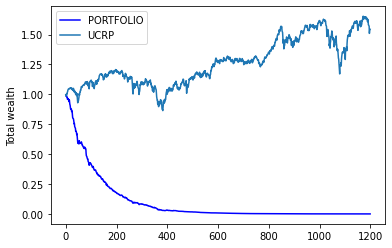


passive_strategy2
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.14
    Sharpe ratio: 0.83 ± 0.53
    Ulcer index: 2.31
    Information ratio (wrt UCRP): 0.44
    Appraisal ratio (wrt UCRP): 0.46 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / 4.046%
    Annualized return: 15.09%
    Annualized volatility: 19.03%
    Longest drawdown: 226 days
    Max drawdown: 29.44%
    Winning days: 54.4%
    Annual turnover: 11.8
        


<Figure size 720x360 with 0 Axes>

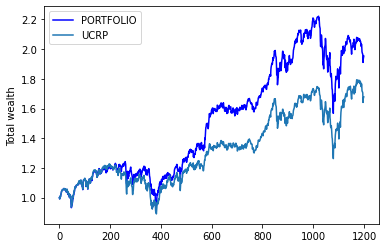

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 1.13
    Sharpe ratio: 0.77 ± 0.52
    Ulcer index: 2.06
    Information ratio (wrt UCRP): 0.28
    Appraisal ratio (wrt UCRP): 0.33 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / 2.845%
    Annualized return: 13.71%
    Annualized volatility: 19.02%
    Longest drawdown: 228 days
    Max drawdown: 29.55%
    Winning days: 54.2%
    Annual turnover: 11.8
        


<Figure size 720x360 with 0 Axes>

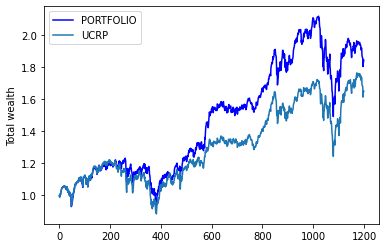

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 1.11
    Sharpe ratio: 0.67 ± 0.51
    Ulcer index: 1.72
    Information ratio (wrt UCRP): 0.03
    Appraisal ratio (wrt UCRP): 0.12 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / 1.044%
    Annualized return: 11.68%
    Annualized volatility: 19.01%
    Longest drawdown: 248 days
    Max drawdown: 29.72%
    Winning days: 54.0%
    Annual turnover: 11.8
        


<Figure size 720x360 with 0 Axes>

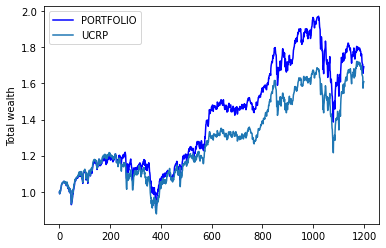

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 1.08
    Sharpe ratio: 0.51 ± 0.49
    Ulcer index: 1.21
    Information ratio (wrt UCRP): -0.39
    Appraisal ratio (wrt UCRP): -0.22 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / -1.958%
    Annualized return: 8.37%
    Annualized volatility: 19.01%
    Longest drawdown: 283 days
    Max drawdown: 30.01%
    Winning days: 53.6%
    Annual turnover: 11.8
        


<Figure size 432x288 with 0 Axes>

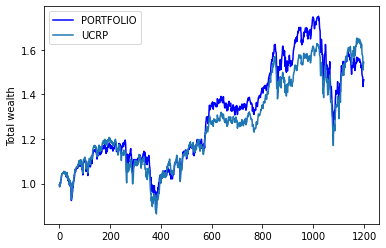

In [16]:
for strategy in strategy_lst:
    strategy_name = strategy.split('(')[0]
    display(strategy_name, concat_results, paras)

In [17]:
for phs in range(12):
    display_phs(strategy_name, results, phs, paras)

Phase 0
ucb_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.02
    Sharpe ratio: 0.21 ± 1.60
    Ulcer index: 0.73
    Information ratio (wrt UCRP): -3.10
    Appraisal ratio (wrt UCRP): -3.04 ± 1.61
    UCRP sharpe: 1.90 ± 2.66
    Beta / Alpha: 1.11 / -30.902%
    Annualized return: 2.29%
    Annualized volatility: 20.38%
    Longest drawdown: 64 days
    Max drawdown: 15.70%
    Winning days: 57.0%
    Annual turnover: 358.0
        
opt_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.01
    Sharpe ratio: 0.16 ± 1.60
    Ulcer index: 0.52
    Information ratio (wrt UCRP): -1.73
    Appraisal ratio (wrt UCRP): -1.89 ± 1.61
    UCRP sharpe: 1.90 ± 2.66
    Beta / Alpha: 1.16 / -32.623%
    Annualized return: 1.00%
    Annualized volatility: 24.85%
    Longest drawdown: 62 days
    Max drawdown: 15.99%
    Winning days: 60.0%
    Annual turnover: 435.2
        
passive_strate

Summary:
    Profit factor: 1.69
    Sharpe ratio: 3.13 ± 3.85
    Ulcer index: 38.07
    Information ratio (wrt UCRP): 2.07
    Appraisal ratio (wrt UCRP): 2.27 ± 1.61
    UCRP sharpe: 2.08 ± 2.82
    Beta / Alpha: 0.81 / 33.864%
    Annualized return: 75.41%
    Annualized volatility: 18.52%
    Longest drawdown: 20 days
    Max drawdown: 4.23%
    Winning days: 56.0%
    Annual turnover: 23.2
        
Phase 6
ucb_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.19
    Sharpe ratio: 1.11 ± 2.02
    Ulcer index: 7.85
    Information ratio (wrt UCRP): 1.28
    Appraisal ratio (wrt UCRP): 1.11 ± 1.60
    UCRP sharpe: 0.33 ± 1.63
    Beta / Alpha: 1.10 / 14.799%
    Annualized return: 19.26%
    Annualized volatility: 17.04%
    Longest drawdown: 41 days
    Max drawdown: 6.12%
    Winning days: 54.0%
    Annual turnover: 335.2
        
opt_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit 

Summary:
    Profit factor: 1.48
    Sharpe ratio: 2.34 ± 3.07
    Ulcer index: 21.20
    Information ratio (wrt UCRP): 2.31
    Appraisal ratio (wrt UCRP): 1.78 ± 1.60
    UCRP sharpe: 2.00 ± 2.75
    Beta / Alpha: 1.10 / 21.755%
    Annualized return: 76.81%
    Annualized volatility: 25.74%
    Longest drawdown: 21 days
    Max drawdown: 9.47%
    Winning days: 59.0%
    Annual turnover: 358.6
        
opt_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.30
    Sharpe ratio: 1.70 ± 2.48
    Ulcer index: 10.57
    Information ratio (wrt UCRP): 0.67
    Appraisal ratio (wrt UCRP): 0.62 ± 1.60
    UCRP sharpe: 2.00 ± 2.75
    Beta / Alpha: 1.00 / 11.749%
    Annualized return: 53.93%
    Annualized volatility: 27.58%
    Longest drawdown: 28 days
    Max drawdown: 11.23%
    Winning days: 58.0%
    Annual turnover: 411.4
        
passive_strategy2
--------------------------------------------------------
fee = 0
Summary:
    Profit 

# Pearson 

## Pearson 0.85 + GGD

    maxiter=2000
    subn=100
    lb=5
    M=10
    inverse='True'
    ggd='True'
    matid='-1 0.85'

    matcnt=$(echo ${matid} | wc -w)
    for i in `seq 0 11`;
    # for i in 10;
    do
        echo "phase $i"
        python main3.py --phase $i --maxiter ${maxiter} --subn ${subn} --lb ${lb} --inverse ${inverse} --matid ${matid} --M ${M} --ggd ${ggd} --gpu 1  > ./log/main2_noval_inv${inverse}_ggd${ggd}_M${M}_iter${maxiter}_mat_pearson_subn${subn}_lb5_s5_log${i}.log
    done

In [48]:
paras={'dataset':'snp500-12', 'maxiter':2000, 'subn':100, 'lb':5, 'M':10, 'inverse':'True', 'ggd':'True',
       'c':0.001, 'rf':0.0007, 'opt_gamma':3, 'passive_eps':1.001, 'passive_gamma':3,
       'mattype':-1, 'dg':0.85
      }

results, concat_results = run(paras, strategy_lst, phase_cnt=12)
# plot_cumulative_return_history(concat_results, strategy_lst, figsize=(10,5))

Phase 0
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 1
Testing...
ucb_strategy
opt_strategy
passive_strategy2


/home/linaiqi/anaconda3/envs/gpfinance/lib/python3.7/site-packages/cvxpy/problems/problem.py:1061: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


Phase 2
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 3
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 4
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 5
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 6
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 7
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 8
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 9
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 10
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 11
Testing...
ucb_strategy
opt_strategy
passive_strategy2


ucb_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.16
    Sharpe ratio: 0.97 ± 0.56
    Ulcer index: 3.17
    Information ratio (wrt UCRP): 0.93
    Appraisal ratio (wrt UCRP): 0.71 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.12 / 9.311%
    Annualized return: 22.87%
    Annualized volatility: 24.10%
    Longest drawdown: 154 days
    Max drawdown: 30.50%
    Winning days: 56.2%
    Annual turnover: 356.6
        
Total wealth: 2.666126531460033


<Figure size 720x360 with 0 Axes>

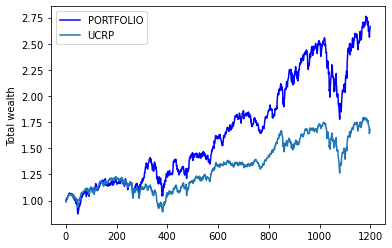

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 0.90
    Sharpe ratio: -0.51 ± 0.49
    Ulcer index: -0.33
    Information ratio (wrt UCRP): -2.13
    Appraisal ratio (wrt UCRP): -2.02 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.12 / -26.280%
    Annualized return: -13.96%
    Annualized volatility: 24.01%
    Longest drawdown: 1185 days
    Max drawdown: 63.46%
    Winning days: 51.7%
    Annual turnover: 356.6
        
Total wealth: 0.48867356482817503


<Figure size 720x360 with 0 Axes>

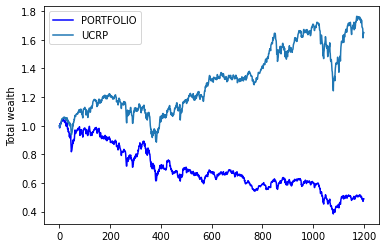

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.61
    Sharpe ratio: -2.75 ± 1.00
    Ulcer index: -0.86
    Information ratio (wrt UCRP): -6.73
    Appraisal ratio (wrt UCRP): -6.11 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.11 / -79.667%
    Annualized return: -49.63%
    Annualized volatility: 23.89%
    Longest drawdown: 1185 days
    Max drawdown: 96.36%
    Winning days: 43.6%
    Annual turnover: 356.6
        
Total wealth: 0.03816716575573216


<Figure size 720x360 with 0 Axes>

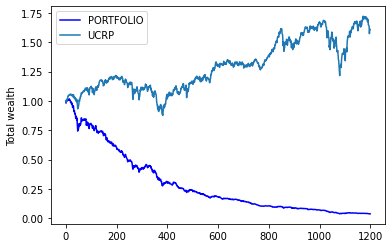

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.31
    Sharpe ratio: -6.52 ± 2.16
    Ulcer index: -1.73
    Information ratio (wrt UCRP): -14.32
    Appraisal ratio (wrt UCRP): -12.84 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.10 / -168.645%
    Annualized return: -79.42%
    Annualized volatility: 23.74%
    Longest drawdown: 1196 days
    Max drawdown: 99.95%
    Winning days: 32.2%
    Annual turnover: 356.6
        
Total wealth: 0.0005378789330492056


<Figure size 432x288 with 0 Axes>

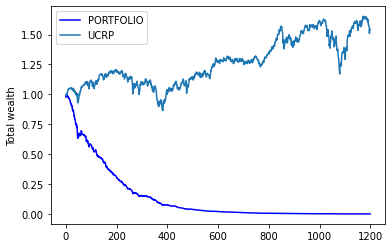


opt_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.18
    Sharpe ratio: 1.10 ± 0.58
    Ulcer index: 3.78
    Information ratio (wrt UCRP): 1.02
    Appraisal ratio (wrt UCRP): 0.85 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.16 / 16.378%
    Annualized return: 31.15%
    Annualized volatility: 28.26%
    Longest drawdown: 155 days
    Max drawdown: 35.85%
    Winning days: 53.8%
    Annual turnover: 417.3
        
Total wealth: 3.637107653771762


<Figure size 720x360 with 0 Axes>

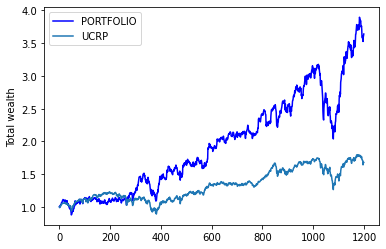

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 0.91
    Sharpe ratio: -0.38 ± 0.47
    Ulcer index: -0.27
    Information ratio (wrt UCRP): -1.30
    Appraisal ratio (wrt UCRP): -1.31 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.16 / -25.257%
    Annualized return: -13.53%
    Annualized volatility: 28.16%
    Longest drawdown: 1185 days
    Max drawdown: 68.64%
    Winning days: 48.4%
    Annual turnover: 417.3
        
Total wealth: 0.5004011778126249


<Figure size 720x360 with 0 Axes>

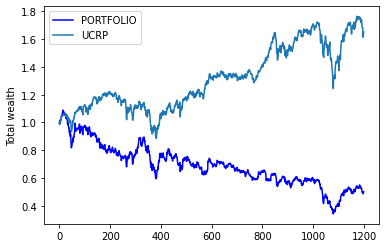

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.62
    Sharpe ratio: -2.61 ± 0.96
    Ulcer index: -0.92
    Information ratio (wrt UCRP): -4.81
    Appraisal ratio (wrt UCRP): -4.57 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.15 / -87.709%
    Annualized return: -53.77%
    Annualized volatility: 28.03%
    Longest drawdown: 1185 days
    Max drawdown: 97.79%
    Winning days: 41.8%
    Annual turnover: 417.3
        
Total wealth: 0.025372733441405882


<Figure size 720x360 with 0 Axes>

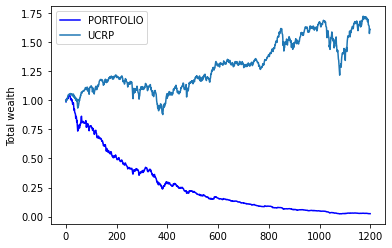

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.33
    Sharpe ratio: -6.37 ± 2.11
    Ulcer index: -1.95
    Information ratio (wrt UCRP): -10.68
    Appraisal ratio (wrt UCRP): -10.00 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.14 / -191.796%
    Annualized return: -83.78%
    Annualized volatility: 27.86%
    Longest drawdown: 1196 days
    Max drawdown: 99.98%
    Winning days: 30.6%
    Annual turnover: 417.3
        
Total wealth: 0.0001732285427825354


<Figure size 432x288 with 0 Axes>

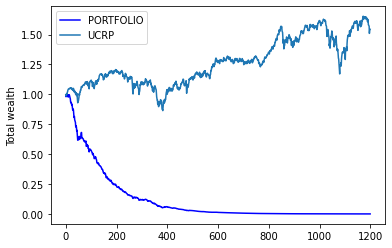


passive_strategy2
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.13
    Sharpe ratio: 0.76 ± 0.52
    Ulcer index: 2.04
    Information ratio (wrt UCRP): 0.28
    Appraisal ratio (wrt UCRP): 0.34 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.94 / 2.289%
    Annualized return: 13.27%
    Annualized volatility: 18.47%
    Longest drawdown: 286 days
    Max drawdown: 28.79%
    Winning days: 55.2%
    Annual turnover: 9.0
        
Total wealth: 1.8101618511458977


<Figure size 720x360 with 0 Axes>

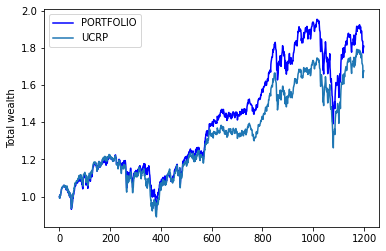

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 1.12
    Sharpe ratio: 0.71 ± 0.51
    Ulcer index: 1.85
    Information ratio (wrt UCRP): 0.11
    Appraisal ratio (wrt UCRP): 0.20 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.94 / 1.375%
    Annualized return: 12.24%
    Annualized volatility: 18.47%
    Longest drawdown: 316 days
    Max drawdown: 28.89%
    Winning days: 55.0%
    Annual turnover: 9.0
        
Total wealth: 1.732799956856098


<Figure size 720x360 with 0 Axes>

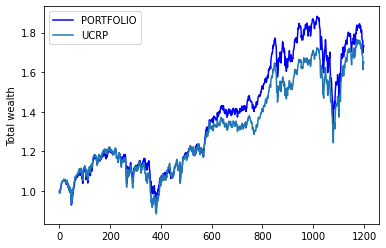

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 1.10
    Sharpe ratio: 0.64 ± 0.50
    Ulcer index: 1.57
    Information ratio (wrt UCRP): -0.15
    Appraisal ratio (wrt UCRP): 0.00 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.94 / 0.003%
    Annualized return: 10.70%
    Annualized volatility: 18.46%
    Longest drawdown: 376 days
    Max drawdown: 29.04%
    Winning days: 54.5%
    Annual turnover: 9.0
        
Total wealth: 1.622864287031048


<Figure size 720x360 with 0 Axes>

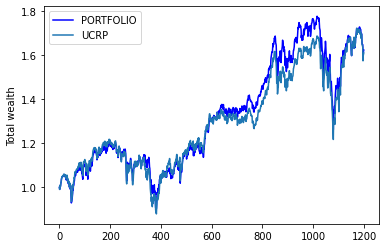

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 1.08
    Sharpe ratio: 0.52 ± 0.49
    Ulcer index: 1.15
    Information ratio (wrt UCRP): -0.58
    Appraisal ratio (wrt UCRP): -0.34 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.94 / -2.283%
    Annualized return: 8.19%
    Annualized volatility: 18.45%
    Longest drawdown: 382 days
    Max drawdown: 29.28%
    Winning days: 54.0%
    Annual turnover: 9.0
        
Total wealth: 1.4548036683829801


<Figure size 432x288 with 0 Axes>

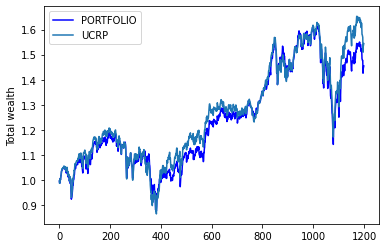

In [49]:
for strategy in strategy_lst:
    strategy_name = strategy.split('(')[0]
    display(strategy_name, concat_results, paras)

# Spearman

## Spearman 0.85 + GGD

In [45]:
paras={'dataset':'snp500-12', 'maxiter':2000, 'subn':100, 'lb':5, 'M':10, 'inverse':'True', 'ggd':'True',
       'c':0.001, 'rf':0.0007, 'opt_gamma':3, 'passive_eps':1.001, 'passive_gamma':3,
       'mattype':-2, 'dg':0.85
      }

results, concat_results = run(paras, strategy_lst, phase_cnt=12)
# plot_cumulative_return_history(concat_results, strategy_lst, figsize=(10,5))

Phase 0
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 1
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 2
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 3
Testing...
ucb_strategy
opt_strategy
passive_strategy2


/home/linaiqi/anaconda3/envs/gpfinance/lib/python3.7/site-packages/cvxpy/problems/problem.py:1061: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


Phase 4
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 5
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 6
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 7
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 8
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 9
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 10
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 11
Testing...
ucb_strategy
opt_strategy
passive_strategy2


ucb_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.16
    Sharpe ratio: 0.97 ± 0.56
    Ulcer index: 3.23
    Information ratio (wrt UCRP): 0.93
    Appraisal ratio (wrt UCRP): 0.72 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.12 / 9.363%
    Annualized return: 22.96%
    Annualized volatility: 24.14%
    Longest drawdown: 154 days
    Max drawdown: 30.46%
    Winning days: 55.9%
    Annual turnover: 357.3
        
Total wealth: 2.67544003918295


<Figure size 720x360 with 0 Axes>

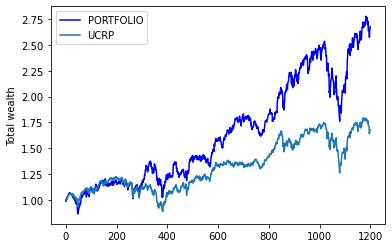

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 0.90
    Sharpe ratio: -0.51 ± 0.49
    Ulcer index: -0.32
    Information ratio (wrt UCRP): -2.13
    Appraisal ratio (wrt UCRP): -2.02 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.12 / -26.293%
    Annualized return: -13.95%
    Annualized volatility: 24.05%
    Longest drawdown: 1185 days
    Max drawdown: 63.89%
    Winning days: 51.2%
    Annual turnover: 357.3
        
Total wealth: 0.4888936007586839


<Figure size 720x360 with 0 Axes>

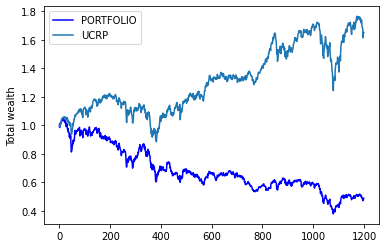

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.61
    Sharpe ratio: -2.75 ± 1.00
    Ulcer index: -0.86
    Information ratio (wrt UCRP): -6.74
    Appraisal ratio (wrt UCRP): -6.13 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.11 / -79.777%
    Annualized return: -49.68%
    Annualized volatility: 23.93%
    Longest drawdown: 1185 days
    Max drawdown: 96.38%
    Winning days: 43.4%
    Annual turnover: 357.3
        
Total wealth: 0.038010095623336314


<Figure size 720x360 with 0 Axes>

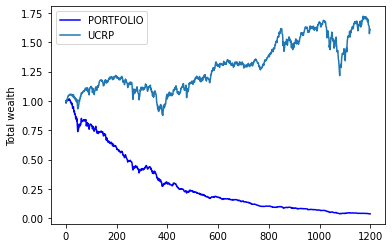

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.31
    Sharpe ratio: -6.52 ± 2.16
    Ulcer index: -1.73
    Information ratio (wrt UCRP): -14.36
    Appraisal ratio (wrt UCRP): -12.89 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.10 / -168.918%
    Annualized return: -79.47%
    Annualized volatility: 23.78%
    Longest drawdown: 1196 days
    Max drawdown: 99.95%
    Winning days: 32.2%
    Annual turnover: 357.3
        
Total wealth: 0.0005315709960653196


<Figure size 432x288 with 0 Axes>

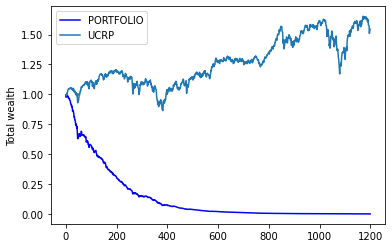


opt_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.19
    Sharpe ratio: 1.12 ± 0.59
    Ulcer index: 3.91
    Information ratio (wrt UCRP): 1.07
    Appraisal ratio (wrt UCRP): 0.89 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.17 / 17.154%
    Annualized return: 32.22%
    Annualized volatility: 28.36%
    Longest drawdown: 155 days
    Max drawdown: 35.61%
    Winning days: 53.8%
    Annual turnover: 417.6
        
Total wealth: 3.781367118198459


<Figure size 720x360 with 0 Axes>

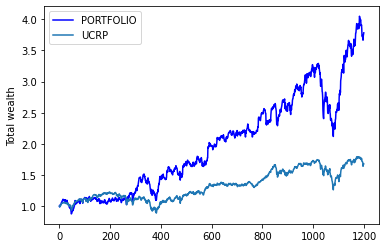

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 0.92
    Sharpe ratio: -0.35 ± 0.47
    Ulcer index: -0.26
    Information ratio (wrt UCRP): -1.25
    Appraisal ratio (wrt UCRP): -1.27 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.16 / -24.517%
    Annualized return: -12.85%
    Annualized volatility: 28.26%
    Longest drawdown: 1185 days
    Max drawdown: 67.43%
    Winning days: 48.5%
    Annual turnover: 417.6
        
Total wealth: 0.5193916802149317


<Figure size 720x360 with 0 Axes>

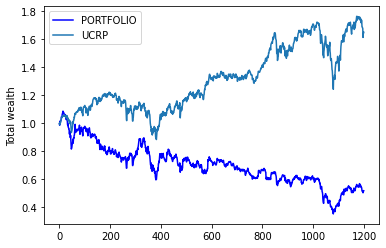

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.62
    Sharpe ratio: -2.57 ± 0.95
    Ulcer index: -0.92
    Information ratio (wrt UCRP): -4.75
    Appraisal ratio (wrt UCRP): -4.53 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.16 / -87.024%
    Annualized return: -53.43%
    Annualized volatility: 28.13%
    Longest drawdown: 1185 days
    Max drawdown: 97.71%
    Winning days: 41.8%
    Annual turnover: 417.6
        
Total wealth: 0.026270362646728447


<Figure size 720x360 with 0 Axes>

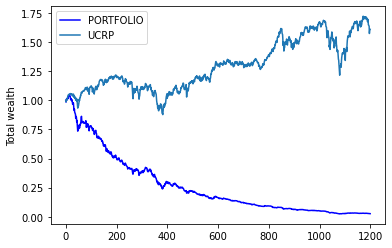

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.33
    Sharpe ratio: -6.32 ± 2.10
    Ulcer index: -1.95
    Information ratio (wrt UCRP): -10.62
    Appraisal ratio (wrt UCRP): -9.96 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.15 / -191.202%
    Annualized return: -83.67%
    Annualized volatility: 27.96%
    Longest drawdown: 1196 days
    Max drawdown: 99.98%
    Winning days: 30.5%
    Annual turnover: 417.6
        
Total wealth: 0.0001786123854614131


<Figure size 432x288 with 0 Axes>

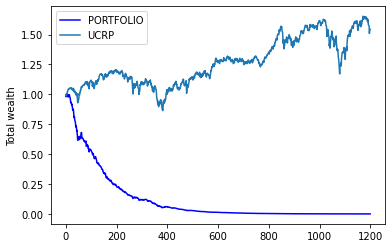


passive_strategy2
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.13
    Sharpe ratio: 0.80 ± 0.53
    Ulcer index: 2.19
    Information ratio (wrt UCRP): 0.39
    Appraisal ratio (wrt UCRP): 0.43 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / 2.889%
    Annualized return: 13.90%
    Annualized volatility: 18.35%
    Longest drawdown: 272 days
    Max drawdown: 28.37%
    Winning days: 54.8%
    Annual turnover: 8.9
        
Total wealth: 1.8581935713438922


<Figure size 720x360 with 0 Axes>

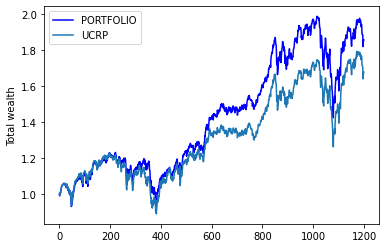

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 1.12
    Sharpe ratio: 0.75 ± 0.52
    Ulcer index: 2.00
    Information ratio (wrt UCRP): 0.21
    Appraisal ratio (wrt UCRP): 0.30 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / 1.986%
    Annualized return: 12.87%
    Annualized volatility: 18.34%
    Longest drawdown: 286 days
    Max drawdown: 28.46%
    Winning days: 54.4%
    Annual turnover: 8.9
        
Total wealth: 1.779685705749746


<Figure size 720x360 with 0 Axes>

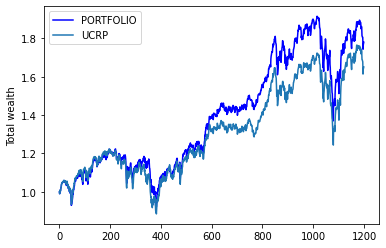

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 1.11
    Sharpe ratio: 0.67 ± 0.51
    Ulcer index: 1.72
    Information ratio (wrt UCRP): -0.05
    Appraisal ratio (wrt UCRP): 0.09 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / 0.632%
    Annualized return: 11.34%
    Annualized volatility: 18.33%
    Longest drawdown: 319 days
    Max drawdown: 28.61%
    Winning days: 54.0%
    Annual turnover: 8.9
        
Total wealth: 1.6680516146523228


<Figure size 720x360 with 0 Axes>

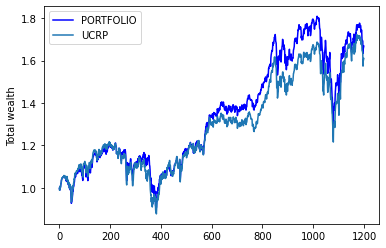

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 1.08
    Sharpe ratio: 0.55 ± 0.49
    Ulcer index: 1.28
    Information ratio (wrt UCRP): -0.47
    Appraisal ratio (wrt UCRP): -0.24 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / -1.625%
    Annualized return: 8.85%
    Annualized volatility: 18.32%
    Longest drawdown: 378 days
    Max drawdown: 28.85%
    Winning days: 53.8%
    Annual turnover: 8.9
        
Total wealth: 1.4972237497055905


<Figure size 432x288 with 0 Axes>

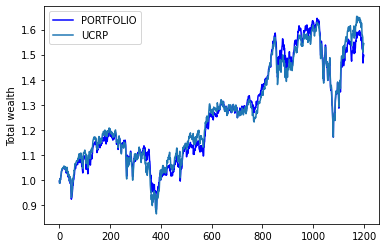

In [46]:
for strategy in strategy_lst:
    strategy_name = strategy.split('(')[0]
    display(strategy_name, concat_results, paras)

In [47]:
for phs in range(12):
    display_phs(strategy_name, results, phs, paras)

Phase 0
ucb_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.20
    Sharpe ratio: 1.22 ± 2.10
    Ulcer index: 4.84
    Information ratio (wrt UCRP): -0.10
    Appraisal ratio (wrt UCRP): -1.08 ± 1.61
    UCRP sharpe: 1.90 ± 2.66
    Beta / Alpha: 1.37 / -12.792%
    Annualized return: 31.36%
    Annualized volatility: 24.87%
    Longest drawdown: 58 days
    Max drawdown: 19.12%
    Winning days: 61.0%
    Annual turnover: 329.4
        
Total wealth: 1.1143026077090161
opt_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.20
    Sharpe ratio: 1.24 ± 2.11
    Ulcer index: 4.63
    Information ratio (wrt UCRP): 0.21
    Appraisal ratio (wrt UCRP): -0.63 ± 1.61
    UCRP sharpe: 1.90 ± 2.66
    Beta / Alpha: 1.44 / -10.400%
    Annualized return: 36.44%
    Annualized volatility: 28.15%
    Longest drawdown: 64 days
    Max drawdown: 21.15%
    Winning days: 59.0%
    Annual turno

Summary:
    Profit factor: 1.22
    Sharpe ratio: 1.34 ± 2.19
    Ulcer index: 10.14
    Information ratio (wrt UCRP): -0.11
    Appraisal ratio (wrt UCRP): -0.38 ± 1.61
    UCRP sharpe: 2.08 ± 2.82
    Beta / Alpha: 1.12 / -4.947%
    Annualized return: 29.87%
    Annualized volatility: 21.13%
    Longest drawdown: 33 days
    Max drawdown: 8.03%
    Winning days: 49.0%
    Annual turnover: 368.7
        
Total wealth: 1.1092819504077247
opt_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.26
    Sharpe ratio: 1.37 ± 2.21
    Ulcer index: 9.65
    Information ratio (wrt UCRP): 0.45
    Appraisal ratio (wrt UCRP): 0.16 ± 1.61
    UCRP sharpe: 2.08 ± 2.82
    Beta / Alpha: 1.21 / 3.615%
    Annualized return: 42.44%
    Annualized volatility: 28.73%
    Longest drawdown: 41 days
    Max drawdown: 9.02%
    Winning days: 46.0%
    Annual turnover: 438.1
        
Total wealth: 1.1507212946702345
passive_strategy2
--------------------

Summary:
    Profit factor: 0.82
    Sharpe ratio: -0.97 ± 1.92
    Ulcer index: -1.92
    Information ratio (wrt UCRP): 0.02
    Appraisal ratio (wrt UCRP): 0.55 ± 1.60
    UCRP sharpe: -1.43 ± 2.26
    Beta / Alpha: 1.29 / 11.462%
    Annualized return: -36.21%
    Annualized volatility: 38.82%
    Longest drawdown: 79 days
    Max drawdown: 35.61%
    Winning days: 44.0%
    Annual turnover: 409.1
        
Total wealth: 0.8366221959655594
passive_strategy2
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 0.75
    Sharpe ratio: -1.52 ± 2.33
    Ulcer index: -3.03
    Information ratio (wrt UCRP): -1.64
    Appraisal ratio (wrt UCRP): -0.62 ± 1.60
    UCRP sharpe: -1.43 ± 2.26
    Beta / Alpha: 1.01 / -1.819%
    Annualized return: -35.29%
    Annualized volatility: 26.35%
    Longest drawdown: 84 days
    Max drawdown: 28.37%
    Winning days: 43.0%
    Annual turnover: 4.8
        
Total wealth: 0.8413656626904825
Phase 11
ucb_strategy
---

## Spearman 0.85 - GGD

In [42]:
paras={'dataset':'snp500-12', 'maxiter':2000, 'subn':100, 'lb':5, 'M':10, 'inverse':'True', 'ggd':'False',
       'c':0.001, 'rf':0.0007, 'opt_gamma':3, 'passive_eps':1.001, 'passive_gamma':3,
       'mattype':-2, 'dg':0.85
      }

results, concat_results = run(paras, strategy_lst, phase_cnt=12)
# plot_cumulative_return_history(concat_results, strategy_lst, figsize=(10,5))

Phase 0
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 1
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 2
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 3
Testing...
ucb_strategy
opt_strategy
passive_strategy2


/home/linaiqi/anaconda3/envs/gpfinance/lib/python3.7/site-packages/cvxpy/problems/problem.py:1061: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


Phase 4
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 5
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 6
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 7
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 8
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 9
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 10
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 11
Testing...
ucb_strategy
opt_strategy
passive_strategy2


ucb_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.12
    Sharpe ratio: 0.81 ± 0.53
    Ulcer index: 2.73
    Information ratio (wrt UCRP): 0.53
    Appraisal ratio (wrt UCRP): 0.40 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.08 / 5.629%
    Annualized return: 17.83%
    Annualized volatility: 23.83%
    Longest drawdown: 167 days
    Max drawdown: 28.24%
    Winning days: 55.2%
    Annual turnover: 349.4
        
Total wealth: 2.1840982810068614


<Figure size 720x360 with 0 Axes>

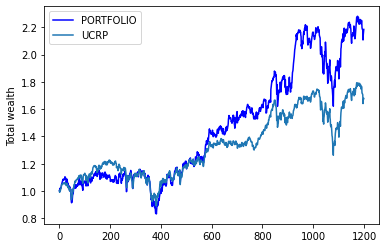

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 0.87
    Sharpe ratio: -0.66 ± 0.51
    Ulcer index: -0.36
    Information ratio (wrt UCRP): -2.28
    Appraisal ratio (wrt UCRP): -2.10 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.07 / -29.304%
    Annualized return: -16.93%
    Annualized volatility: 23.78%
    Longest drawdown: 1177 days
    Max drawdown: 66.21%
    Winning days: 50.8%
    Annual turnover: 349.4
        
Total wealth: 0.41339332004604074


<Figure size 720x360 with 0 Axes>

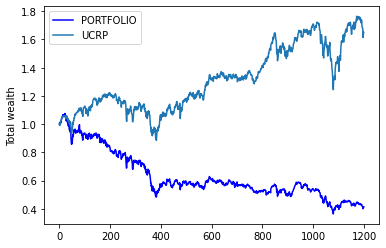

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.60
    Sharpe ratio: -2.88 ± 1.04
    Ulcer index: -0.87
    Information ratio (wrt UCRP): -6.49
    Appraisal ratio (wrt UCRP): -5.85 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.07 / -81.702%
    Annualized return: -50.87%
    Annualized volatility: 23.72%
    Longest drawdown: 1185 days
    Max drawdown: 96.83%
    Winning days: 43.1%
    Annual turnover: 349.4
        
Total wealth: 0.03388764607511397


<Figure size 720x360 with 0 Axes>

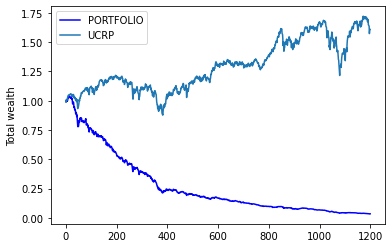

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.31
    Sharpe ratio: -6.58 ± 2.18
    Ulcer index: -1.73
    Information ratio (wrt UCRP): -13.46
    Appraisal ratio (wrt UCRP): -12.05 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.06 / -169.034%
    Annualized return: -79.58%
    Annualized volatility: 23.66%
    Longest drawdown: 1199 days
    Max drawdown: 99.95%
    Winning days: 32.8%
    Annual turnover: 349.4
        
Total wealth: 0.0005179103963145253


<Figure size 432x288 with 0 Axes>

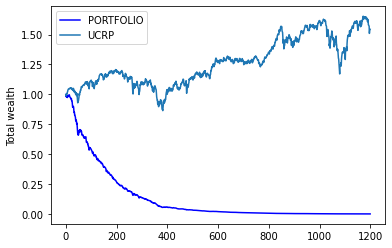


opt_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.06
    Sharpe ratio: 0.49 ± 0.48
    Ulcer index: 1.00
    Information ratio (wrt UCRP): 0.06
    Appraisal ratio (wrt UCRP): -0.01 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.11 / -0.300%
    Annualized return: 10.31%
    Annualized volatility: 28.06%
    Longest drawdown: 439 days
    Max drawdown: 40.10%
    Winning days: 53.8%
    Annual turnover: 407.1
        
Total wealth: 1.595347115965751


<Figure size 720x360 with 0 Axes>

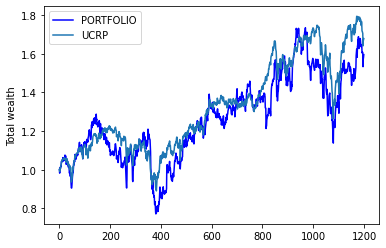

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 0.82
    Sharpe ratio: -0.97 ± 0.56
    Ulcer index: -0.49
    Information ratio (wrt UCRP): -2.12
    Appraisal ratio (wrt UCRP): -2.03 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.11 / -40.987%
    Annualized return: -26.60%
    Annualized volatility: 28.00%
    Longest drawdown: 1185 days
    Max drawdown: 80.91%
    Winning days: 48.8%
    Annual turnover: 407.1
        
Total wealth: 0.22936140608997738


<Figure size 720x360 with 0 Axes>

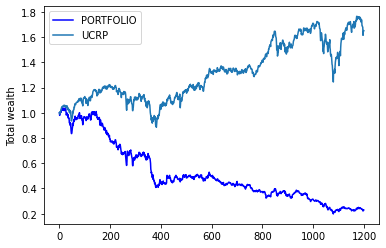

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.56
    Sharpe ratio: -3.16 ± 1.12
    Ulcer index: -1.07
    Information ratio (wrt UCRP): -5.38
    Appraisal ratio (wrt UCRP): -5.05 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.10 / -102.016%
    Annualized return: -60.21%
    Annualized volatility: 27.93%
    Longest drawdown: 1189 days
    Max drawdown: 98.80%
    Winning days: 40.8%
    Annual turnover: 407.1
        
Total wealth: 0.012426102325049532


<Figure size 720x360 with 0 Axes>

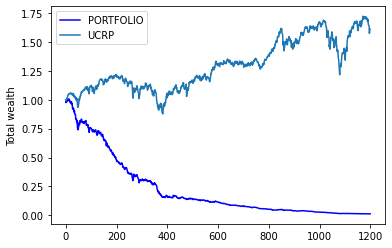

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.29
    Sharpe ratio: -6.81 ± 2.26
    Ulcer index: -2.07
    Information ratio (wrt UCRP): -10.79
    Appraisal ratio (wrt UCRP): -10.05 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.09 / -203.732%
    Annualized return: -85.71%
    Annualized volatility: 27.88%
    Longest drawdown: 1199 days
    Max drawdown: 99.99%
    Winning days: 30.0%
    Annual turnover: 407.1
        
Total wealth: 9.480445921149797e-05


<Figure size 432x288 with 0 Axes>

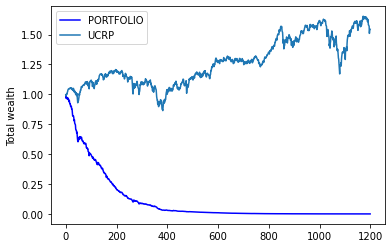


passive_strategy2
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.13
    Sharpe ratio: 0.78 ± 0.52
    Ulcer index: 2.15
    Information ratio (wrt UCRP): 0.29
    Appraisal ratio (wrt UCRP): 0.34 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / 3.171%
    Annualized return: 13.98%
    Annualized volatility: 19.13%
    Longest drawdown: 226 days
    Max drawdown: 29.43%
    Winning days: 54.8%
    Annual turnover: 10.7
        
Total wealth: 1.8650370344259994


<Figure size 720x360 with 0 Axes>

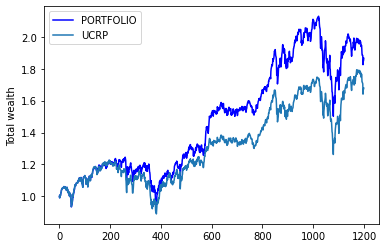

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 1.12
    Sharpe ratio: 0.72 ± 0.51
    Ulcer index: 1.93
    Information ratio (wrt UCRP): 0.15
    Appraisal ratio (wrt UCRP): 0.23 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / 2.086%
    Annualized return: 12.75%
    Annualized volatility: 19.12%
    Longest drawdown: 228 days
    Max drawdown: 29.54%
    Winning days: 54.7%
    Annual turnover: 10.7
        
Total wealth: 1.7710947219959348


<Figure size 720x360 with 0 Axes>

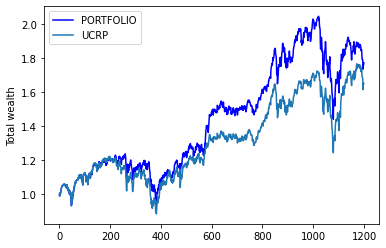

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 1.10
    Sharpe ratio: 0.63 ± 0.50
    Ulcer index: 1.62
    Information ratio (wrt UCRP): -0.06
    Appraisal ratio (wrt UCRP): 0.05 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / 0.458%
    Annualized return: 10.93%
    Annualized volatility: 19.12%
    Longest drawdown: 249 days
    Max drawdown: 29.72%
    Winning days: 54.4%
    Annual turnover: 10.7
        
Total wealth: 1.6389175361629347


<Figure size 720x360 with 0 Axes>

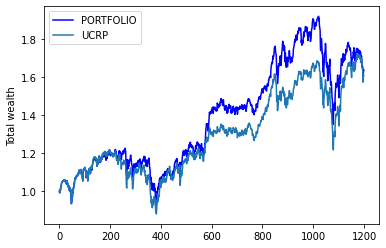

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 1.07
    Sharpe ratio: 0.49 ± 0.49
    Ulcer index: 1.16
    Information ratio (wrt UCRP): -0.41
    Appraisal ratio (wrt UCRP): -0.24 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / -2.254%
    Annualized return: 7.96%
    Annualized volatility: 19.12%
    Longest drawdown: 316 days
    Max drawdown: 30.00%
    Winning days: 54.2%
    Annual turnover: 10.7
        
Total wealth: 1.4400338046785892


<Figure size 432x288 with 0 Axes>

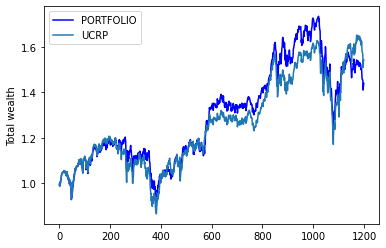

In [43]:
for strategy in strategy_lst:
    strategy_name = strategy.split('(')[0]
    display(strategy_name, concat_results, paras)

In [44]:
for phs in range(12):
    display_phs(strategy_name, results, phs, paras)

Phase 0
ucb_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.13
    Sharpe ratio: 0.88 ± 1.87
    Ulcer index: 3.12
    Information ratio (wrt UCRP): -1.00
    Appraisal ratio (wrt UCRP): -1.44 ± 1.61
    UCRP sharpe: 1.90 ± 2.66
    Beta / Alpha: 1.21 / -17.923%
    Annualized return: 19.26%
    Annualized volatility: 22.75%
    Longest drawdown: 56 days
    Max drawdown: 17.26%
    Winning days: 58.0%
    Annual turnover: 337.6
        
Total wealth: 1.072386290024376
opt_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.25
    Sharpe ratio: 1.52 ± 2.33
    Ulcer index: 7.05
    Information ratio (wrt UCRP): 0.33
    Appraisal ratio (wrt UCRP): -0.18 ± 1.61
    UCRP sharpe: 1.90 ± 2.66
    Beta / Alpha: 1.21 / -2.452%
    Annualized return: 39.27%
    Annualized volatility: 23.63%
    Longest drawdown: 39 days
    Max drawdown: 15.90%
    Winning days: 60.0%
    Annual turnove

Summary:
    Profit factor: 1.35
    Sharpe ratio: 1.92 ± 2.68
    Ulcer index: 16.18
    Information ratio (wrt UCRP): 0.89
    Appraisal ratio (wrt UCRP): 0.63 ± 1.61
    UCRP sharpe: 2.08 ± 2.82
    Beta / Alpha: 1.08 / 8.983%
    Annualized return: 47.30%
    Annualized volatility: 21.27%
    Longest drawdown: 30 days
    Max drawdown: 6.33%
    Winning days: 56.0%
    Annual turnover: 334.1
        
Total wealth: 1.1661459935441476
opt_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.22
    Sharpe ratio: 1.29 ± 2.15
    Ulcer index: 10.64
    Information ratio (wrt UCRP): 0.14
    Appraisal ratio (wrt UCRP): 0.02 ± 1.61
    UCRP sharpe: 2.08 ± 2.82
    Beta / Alpha: 1.07 / 0.332%
    Annualized return: 33.70%
    Annualized volatility: 24.79%
    Longest drawdown: 19 days
    Max drawdown: 8.55%
    Winning days: 53.0%
    Annual turnover: 357.5
        
Total wealth: 1.1221695122924333
passive_strategy2
----------------------

Summary:
    Profit factor: 0.75
    Sharpe ratio: -1.52 ± 2.33
    Ulcer index: -3.00
    Information ratio (wrt UCRP): -1.05
    Appraisal ratio (wrt UCRP): -0.40 ± 1.60
    UCRP sharpe: -1.43 ± 2.26
    Beta / Alpha: 1.07 / -2.477%
    Annualized return: -37.51%
    Annualized volatility: 28.27%
    Longest drawdown: 78 days
    Max drawdown: 29.43%
    Winning days: 46.0%
    Annual turnover: 7.1
        
Total wealth: 0.8298243127328206
Phase 11
ucb_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.29
    Sharpe ratio: 1.56 ± 2.36
    Ulcer index: 13.40
    Information ratio (wrt UCRP): 0.11
    Appraisal ratio (wrt UCRP): 0.08 ± 1.60
    UCRP sharpe: 2.00 ± 2.75
    Beta / Alpha: 1.00 / 0.788%
    Annualized return: 39.76%
    Annualized volatility: 23.11%
    Longest drawdown: 27 days
    Max drawdown: 7.63%
    Winning days: 55.0%
    Annual turnover: 351.6
        
Total wealth: 1.1420762401885785
opt_strategy
-------------

# Kandell

## Kandell 0.7 + GGD

In [40]:
paras={'dataset':'snp500-12', 'maxiter':2000, 'subn':100, 'lb':5, 'M':10, 'inverse':'True', 'ggd':'True',
       'c':0.001, 'rf':0.0007, 'opt_gamma':3, 'passive_eps':1.001, 'passive_gamma':3,
       'mattype':-3, 'dg':0.7
      }

results, concat_results = run(paras, strategy_lst, phase_cnt=12)
# plot_cumulative_return_history(concat_results, strategy_lst, figsize=(10,5))

Phase 0
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 1
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 2
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 3
Testing...
ucb_strategy
opt_strategy
passive_strategy2


/home/linaiqi/anaconda3/envs/gpfinance/lib/python3.7/site-packages/cvxpy/problems/problem.py:1061: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


Phase 4
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 5
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 6
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 7
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 8
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 9
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 10
Testing...
ucb_strategy
opt_strategy
passive_strategy2
Phase 11
Testing...
ucb_strategy
opt_strategy
passive_strategy2


ucb_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.15
    Sharpe ratio: 0.95 ± 0.55
    Ulcer index: 3.10
    Information ratio (wrt UCRP): 0.90
    Appraisal ratio (wrt UCRP): 0.68 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.12 / 8.874%
    Annualized return: 22.37%
    Annualized volatility: 24.14%
    Longest drawdown: 154 days
    Max drawdown: 31.05%
    Winning days: 55.8%
    Annual turnover: 357.5
        
Total wealth: 2.615414202121264


<Figure size 720x360 with 0 Axes>

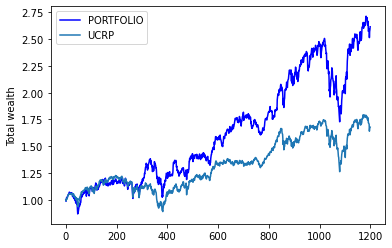

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 0.89
    Sharpe ratio: -0.53 ± 0.49
    Ulcer index: -0.33
    Information ratio (wrt UCRP): -2.17
    Appraisal ratio (wrt UCRP): -2.06 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.12 / -26.801%
    Annualized return: -14.38%
    Annualized volatility: 24.05%
    Longest drawdown: 1185 days
    Max drawdown: 64.60%
    Winning days: 51.2%
    Annual turnover: 357.5
        
Total wealth: 0.47746033796594356


<Figure size 720x360 with 0 Axes>

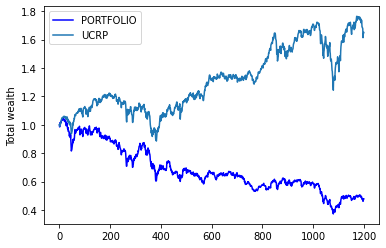

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.61
    Sharpe ratio: -2.77 ± 1.01
    Ulcer index: -0.87
    Information ratio (wrt UCRP): -6.80
    Appraisal ratio (wrt UCRP): -6.18 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.11 / -80.315%
    Annualized return: -49.94%
    Annualized volatility: 23.93%
    Longest drawdown: 1185 days
    Max drawdown: 96.47%
    Winning days: 43.2%
    Annual turnover: 357.5
        
Total wealth: 0.03706703117618413


<Figure size 720x360 with 0 Axes>

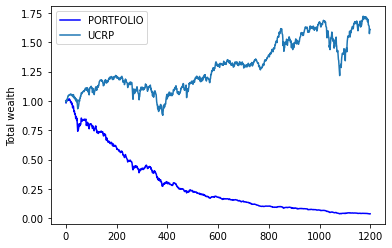

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.31
    Sharpe ratio: -6.54 ± 2.17
    Ulcer index: -1.74
    Information ratio (wrt UCRP): -14.44
    Appraisal ratio (wrt UCRP): -12.96 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.10 / -169.504%
    Annualized return: -79.59%
    Annualized volatility: 23.78%
    Longest drawdown: 1196 days
    Max drawdown: 99.95%
    Winning days: 31.9%
    Annual turnover: 357.5
        
Total wealth: 0.0005171202661658167


<Figure size 432x288 with 0 Axes>

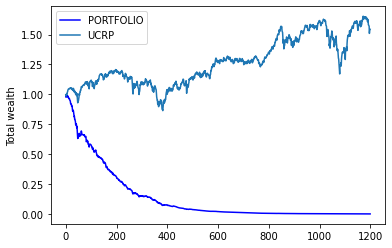


opt_strategy
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.18
    Sharpe ratio: 1.11 ± 0.58
    Ulcer index: 3.84
    Information ratio (wrt UCRP): 1.05
    Appraisal ratio (wrt UCRP): 0.86 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.17 / 16.710%
    Annualized return: 31.66%
    Annualized volatility: 28.35%
    Longest drawdown: 155 days
    Max drawdown: 35.62%
    Winning days: 53.8%
    Annual turnover: 417.6
        
Total wealth: 3.7049308904915677


<Figure size 720x360 with 0 Axes>

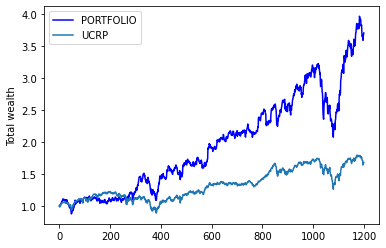

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 0.92
    Sharpe ratio: -0.36 ± 0.47
    Ulcer index: -0.27
    Information ratio (wrt UCRP): -1.27
    Appraisal ratio (wrt UCRP): -1.30 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.17 / -24.964%
    Annualized return: -13.23%
    Annualized volatility: 28.25%
    Longest drawdown: 1185 days
    Max drawdown: 68.08%
    Winning days: 48.3%
    Annual turnover: 417.6
        
Total wealth: 0.5088269851756521


<Figure size 720x360 with 0 Axes>

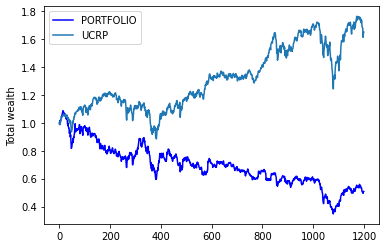

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.62
    Sharpe ratio: -2.59 ± 0.96
    Ulcer index: -0.92
    Information ratio (wrt UCRP): -4.79
    Appraisal ratio (wrt UCRP): -4.56 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.16 / -87.475%
    Annualized return: -53.63%
    Annualized volatility: 28.12%
    Longest drawdown: 1185 days
    Max drawdown: 97.76%
    Winning days: 42.0%
    Annual turnover: 417.6
        
Total wealth: 0.025730994084013404


<Figure size 720x360 with 0 Axes>

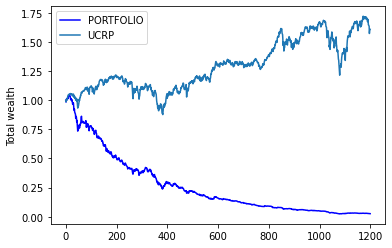

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.33
    Sharpe ratio: -6.34 ± 2.10
    Ulcer index: -1.95
    Information ratio (wrt UCRP): -10.66
    Appraisal ratio (wrt UCRP): -10.00 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 1.15 / -191.659%
    Annualized return: -83.75%
    Annualized volatility: 27.96%
    Longest drawdown: 1196 days
    Max drawdown: 99.98%
    Winning days: 30.4%
    Annual turnover: 417.6
        
Total wealth: 0.0001748878842859355


<Figure size 432x288 with 0 Axes>

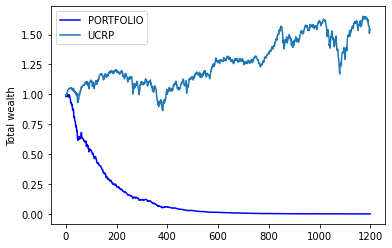


passive_strategy2
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.13
    Sharpe ratio: 0.77 ± 0.52
    Ulcer index: 2.04
    Information ratio (wrt UCRP): 0.28
    Appraisal ratio (wrt UCRP): 0.34 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / 2.364%
    Annualized return: 13.31%
    Annualized volatility: 18.42%
    Longest drawdown: 294 days
    Max drawdown: 28.33%
    Winning days: 54.5%
    Annual turnover: 8.9
        
Total wealth: 1.8127221137465703


<Figure size 720x360 with 0 Axes>

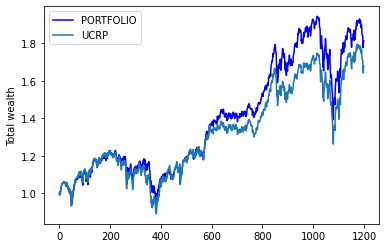

--------------------------------------------------------
fee = 0.001000
Summary:
    Profit factor: 1.12
    Sharpe ratio: 0.72 ± 0.51
    Ulcer index: 1.84
    Information ratio (wrt UCRP): 0.11
    Appraisal ratio (wrt UCRP): 0.21 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / 1.462%
    Annualized return: 12.28%
    Annualized volatility: 18.42%
    Longest drawdown: 376 days
    Max drawdown: 28.42%
    Winning days: 54.2%
    Annual turnover: 8.9
        
Total wealth: 1.736230803259915


<Figure size 720x360 with 0 Axes>

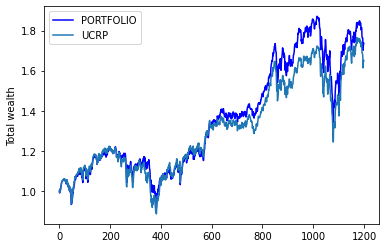

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 1.10
    Sharpe ratio: 0.64 ± 0.50
    Ulcer index: 1.55
    Information ratio (wrt UCRP): -0.14
    Appraisal ratio (wrt UCRP): 0.02 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / 0.108%
    Annualized return: 10.77%
    Annualized volatility: 18.41%
    Longest drawdown: 378 days
    Max drawdown: 28.57%
    Winning days: 53.7%
    Annual turnover: 8.9
        
Total wealth: 1.6274557737235962


<Figure size 720x360 with 0 Axes>

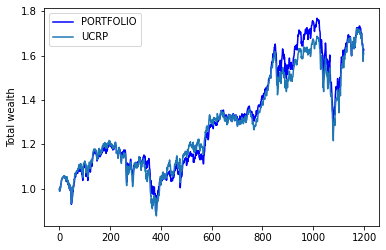

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 1.08
    Sharpe ratio: 0.52 ± 0.49
    Ulcer index: 1.13
    Information ratio (wrt UCRP): -0.55
    Appraisal ratio (wrt UCRP): -0.31 ± 0.46
    UCRP sharpe: 0.67 ± 0.51
    Beta / Alpha: 0.93 / -2.148%
    Annualized return: 8.29%
    Annualized volatility: 18.40%
    Longest drawdown: 393 days
    Max drawdown: 28.81%
    Winning days: 53.2%
    Annual turnover: 8.9
        
Total wealth: 1.4609827069301875


<Figure size 432x288 with 0 Axes>

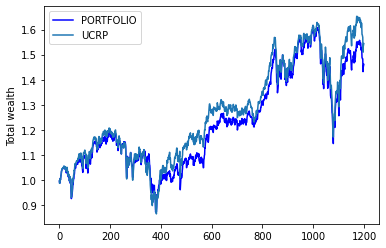

In [41]:
for strategy in strategy_lst:
    strategy_name = strategy.split('(')[0]
    display(strategy_name, concat_results, paras)